# Predict Object masks from prompts with SAM

Necessary imports 

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

Helper function

In [90]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis = 0) # RGBA color (Red, Green, Blue, Alpha)
    else:
        color = np.array([30/255,144/255,255/255,0.6])
    
    h,w = mask.shape[-2:]
    mask_image = mask.reshape(h,w,1)*color.reshape(1,1,-1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

Test Image

In [91]:
image = cv2.imread('/home/phukon/Desktop/Model_Fitting/SAM_test/CEP_318_2023_XR_sl_719.png')
image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGB)

Plot test image

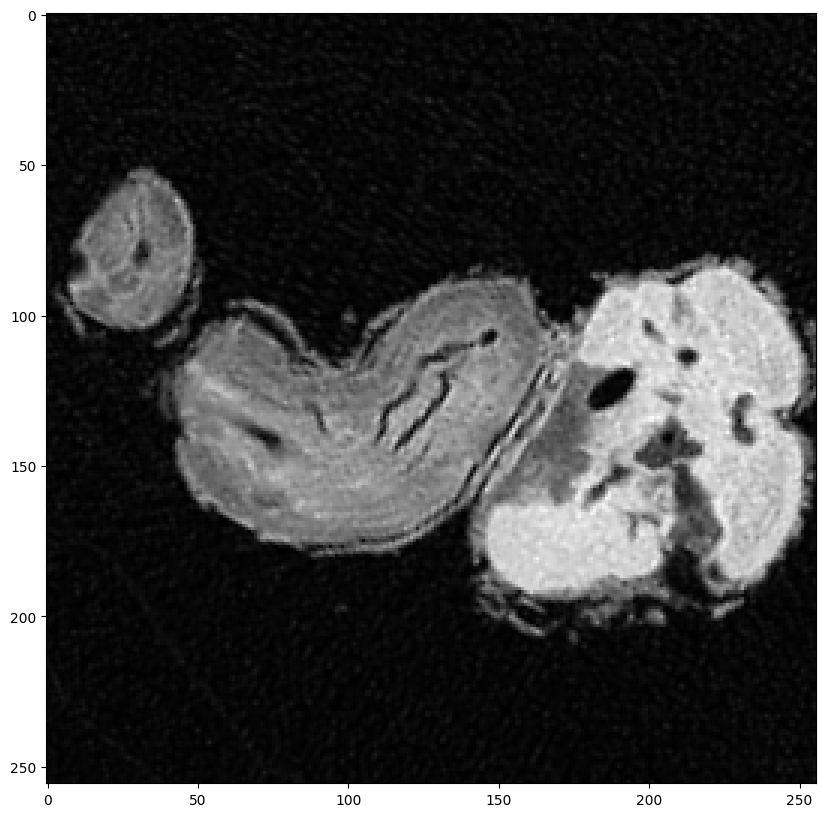

In [92]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

## Selecting objects with SAM


1. Load SAM model
2. Load Predictor
3. Load SAM checkpoint
4. Run on CUDA (set device) 

In [93]:
from segment_anything import sam_model_registry, SamPredictor

In [94]:
sam_checkpoint = "/home/phukon/Desktop/Model_Fitting/SAM_test/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"


sam = sam_model_registry[model_type](checkpoint = sam_checkpoint)
sam.to(device)

predictor = SamPredictor(sam)

/home/phukon/miniconda3/envs/seg_env/lib/python3.12/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)

Process the image to produce an image embedding by calling SamPredictor.set_image. SamPredictor remembers this embedding and will use it for subsequent mask prediction.

In [95]:
predictor.set_image(image)

In [96]:
input_point = np.array([[180,180]])
input_label = np.array([1])


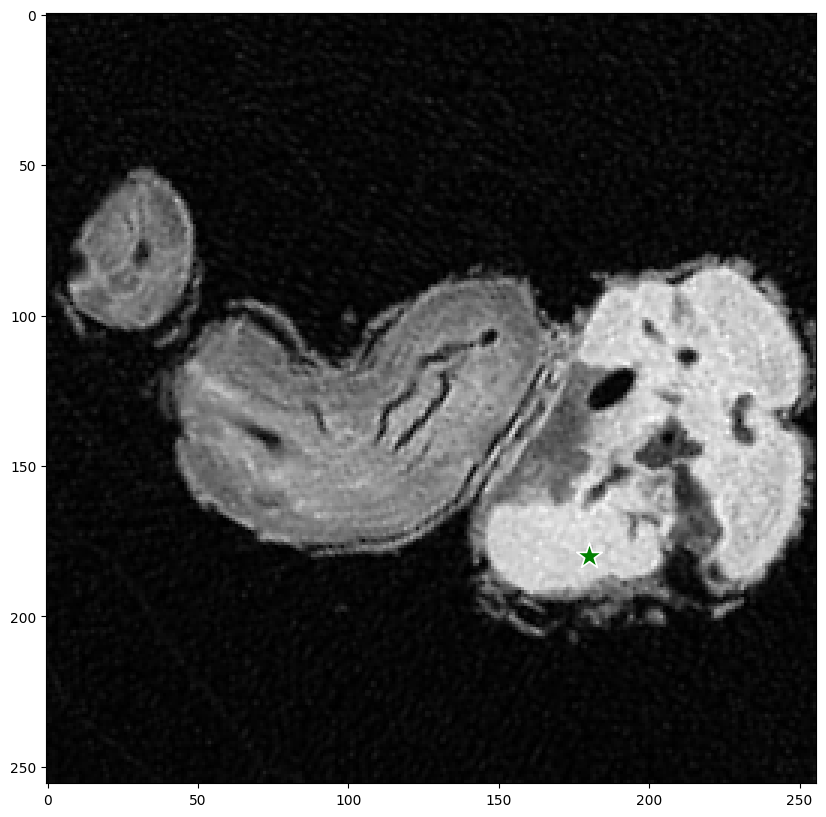

In [97]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [98]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [99]:
masks.shape

(3, 256, 256)

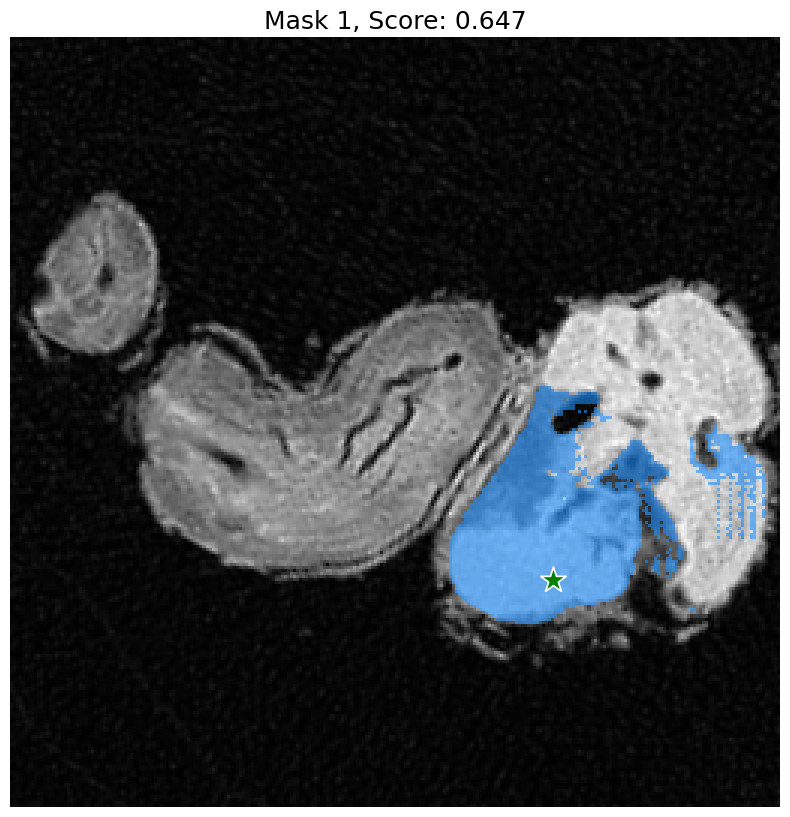

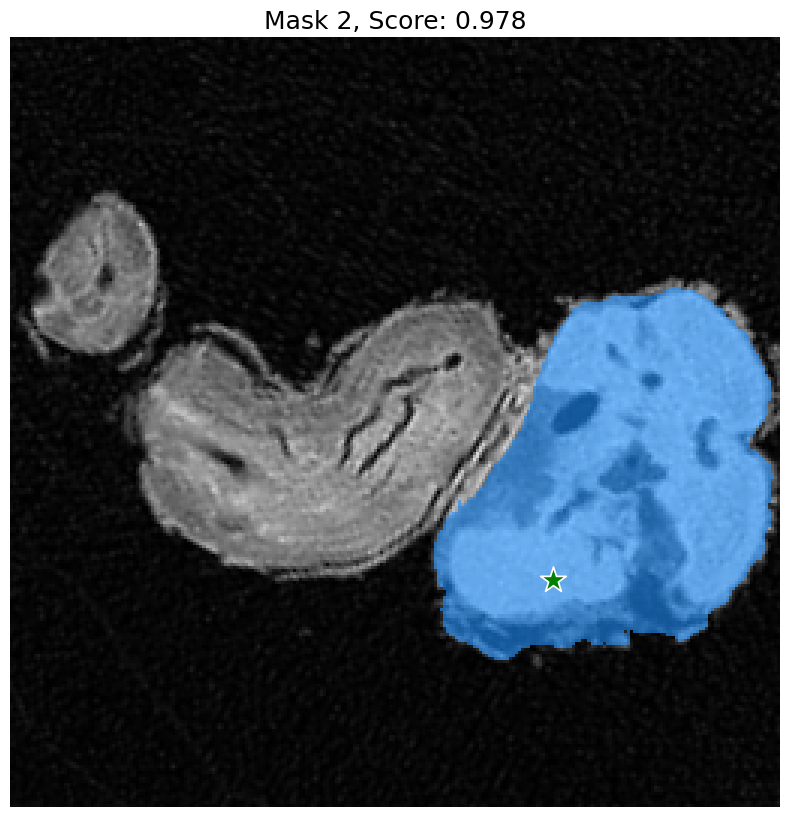

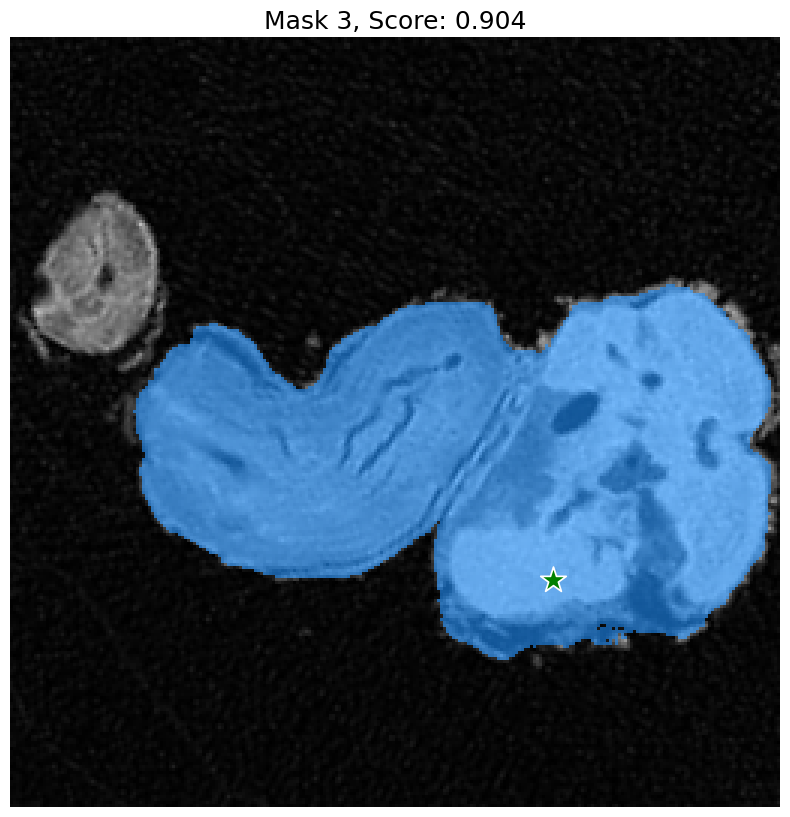

In [100]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

## Specifying a specific object with additional points

In [101]:
input_point = np.array([[180,180],[240,110]])
input_label = np.array([1,1])

mask_input = logits[np.argmax(scores),:,:]

In [102]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

In [103]:
masks.shape

(1, 256, 256)

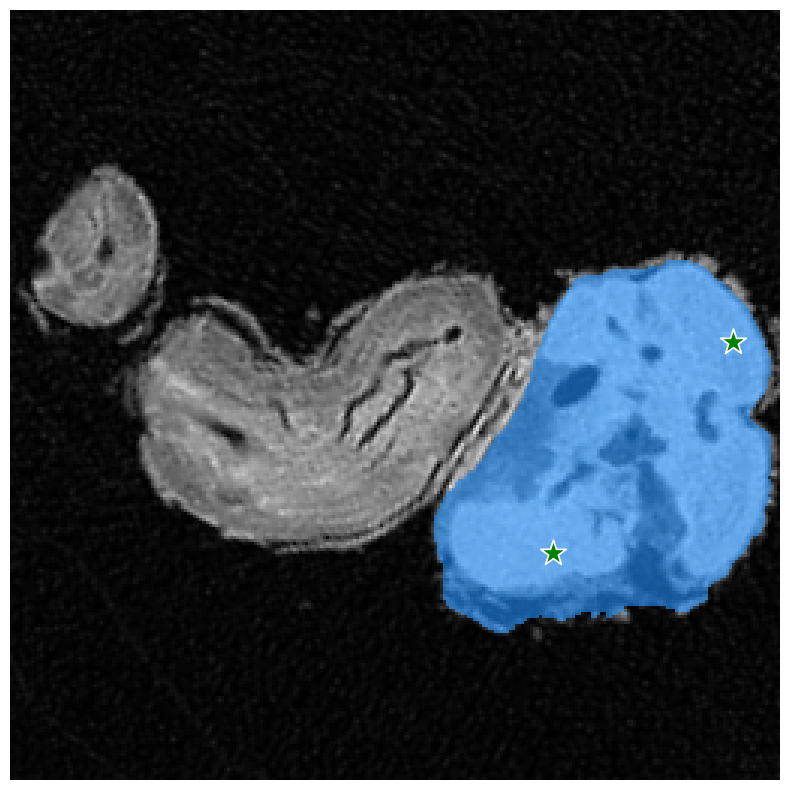

In [104]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

In [105]:
input_point = np.array([[180,180],[240,110], [170,134]])
input_label = np.array([1, 1, 0])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [106]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

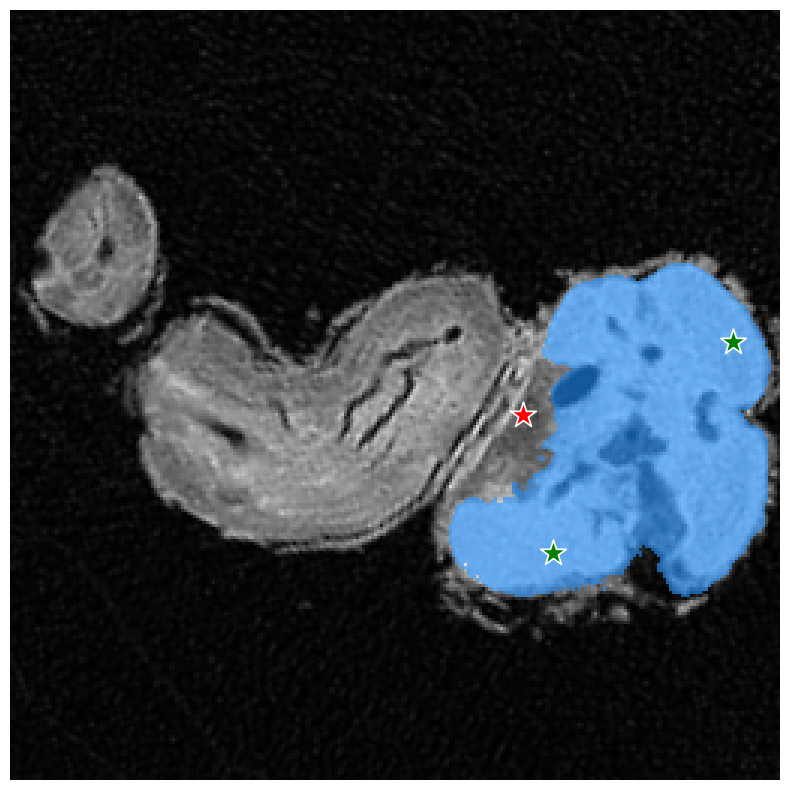

In [107]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

End-to-end batched inference

In [108]:
from segment_anything.utils.transforms import ResizeLongestSide
resize_transform = ResizeLongestSide(sam.image_encoder.img_size)

In [109]:
def prepare_image(image, transform, device):
    image = transform.apply_image(image)
    image = torch.as_tensor(image, device=device.device)
    return image.permute(2,0,1).contiguous()

In [110]:
image1 = image
image2 = cv2.imread('/home/phukon/Desktop/Model_Fitting/SAM_test/CEP_322_2024_XR_sl_660.png')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

In [115]:
batched_input = [
    {
        'image': prepare_image(image1, resize_transform, sam),
        'original_size': image1.shape[:2]
    },
    {
        'image': prepare_image(image2, resize_transform, sam),
        'original_size': image2.shape[:2]
    }
]

In [116]:
batched_output = sam(batched_input, multimask_output=False)

In [117]:
batched_output[0].keys()

dict_keys(['masks', 'iou_predictions', 'low_res_logits'])

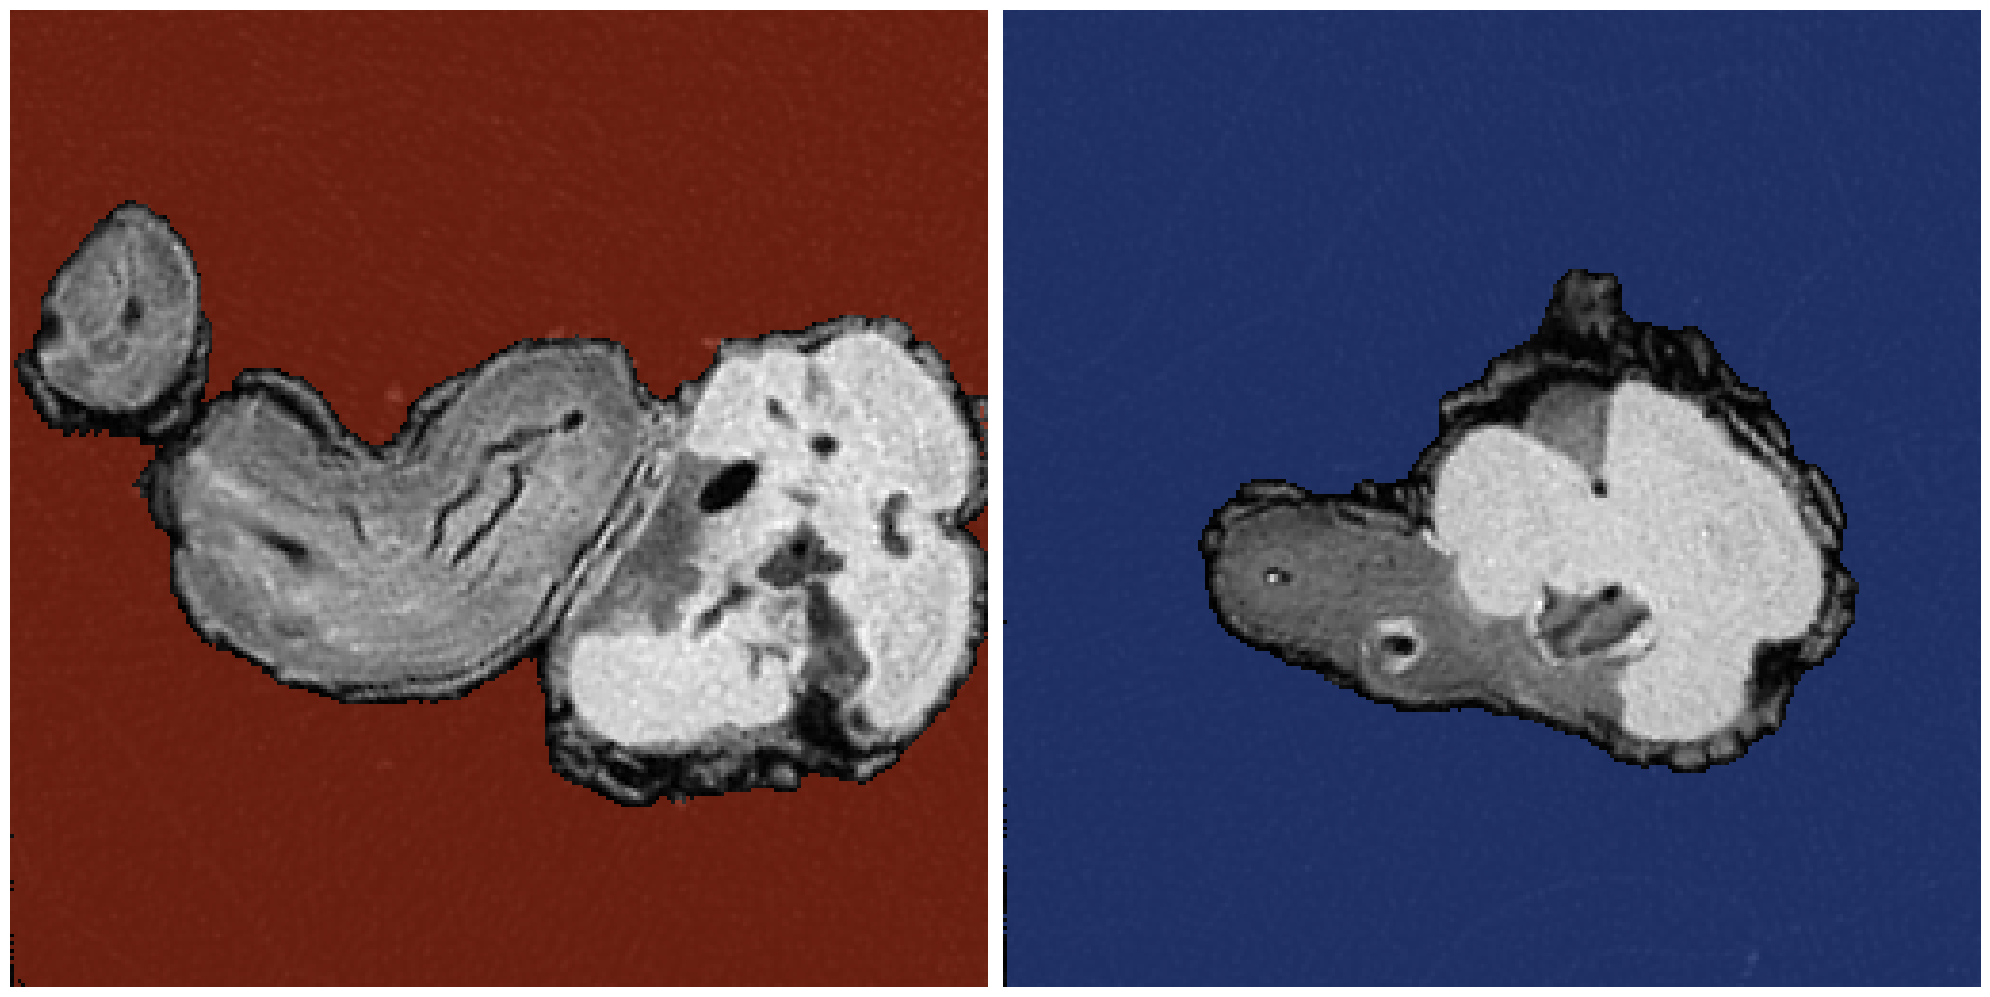

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))

ax[0].imshow(image1)
for mask in batched_output[0]['masks']:
    show_mask(mask.cpu().numpy(), ax[0], random_color=True)
ax[0].axis('off')

ax[1].imshow(image2)
for mask in batched_output[1]['masks']:
    show_mask(mask.cpu().numpy(), ax[1], random_color=True)
ax[1].axis('off')

plt.tight_layout()
plt.show()
